## Introduction and Problem Description

For the DTSA 5509 Final project I will focus on solving an NLP classification problem with a Logistic Regression classifier and a Random Forest classifier.

As dataset I will use a dutch dataset containing 103K labelled newspaper articles. The dataset is described and analyzed further below in this notebook.

I used the dataset in an earlier personal project to solve classification problems with state of the art NLP Transformer models. With the requirements for this final project I got the idea to explore that same dataset again but then based on the more traditional NLP approach.

As described I will train a Logistic Regression classifier and a Random Forest classifier. There are multiple ways to encode the text before we can train any of those models on it. A basic method to encode the text is with the use of the Sklearn Count Vectorizer. With the Count Vectorizer the text is encoded based on the word count. As preprocessing for the text the only actions that will be performed by the CountVectorizer is lowercasing the text and removing any of the stop words.

With the Count Vectorizer we can specify the amount of features to use. That is, we specify the Top K number of words that it will take into account.

In the EDA we will see that the news articles are of varying length for the number of words that they contain. We will use different amounts of words in our experimentation.

To summarize, the questions I want to see answered based on the experimentation are the following:
* What is the effect of using a different number of input words from the text by setting a maximum on the number of input words?
* What is the effect of using a different number of features for the Count Vectorizer?
* How do the Logistic Regression and Random Forest classifier models compare to each other?

## Modules

To start...lets import all modules first...

In [1]:
import os
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Token Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Sklearn Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Surpress Sklearn convergence warnings
# ...because of total runtime we set the number of iterations fixed. The following code prevents the warnings.
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category = ConvergenceWarning)

## Dataset

The dataset I will be using is a dutch dataset with roughly 103K of newspaper articles. The idea of the dataset was to label each article on whether it is a politicized news article or not. If we would train a classification model on this dataset we would be able to recognize whether a newspaper article is written in a Neutral/Objective style or in a Partisan style as the creators of the dataset called it.

In an earlier personal project I did some experiments with this dataset in combination with NLP Transformer models. For that I had already uploaded the dataset to a Kaggle Dataset

The dataset "partisan-news2019" was published originally on the following github https://github.com/dpgmedia/partisan-news2019. When creating this notebook I noticed that one of the download links on the github page wasn't working anymore. Because of that reason I downloaded the 2 dataset files to my local drive (they are not included in this submission or my github) in the same folder as the Jupyter Notebook. If you want to reproduce the results locally then you can download the below mentioned files from the Kaggle Dataset (you will need a Kaggle User Account for that..): https://www.kaggle.com/datasets/rsmits/dpgmedia2019 

In [2]:
# https://github.com/dpgmedia/partisan-news2019
# https://www.kaggle.com/datasets/rsmits/dpgmedia2019

def get_dpgnews_df(cache_dir: str)->pd.DataFrame:
    # Set 1: Articles
    articles_df = pd.read_json(os.path.join(cache_dir, 'dpgMedia2019-articles-bypublisher.jsonl'), lines = True)
    articles_df = articles_df.set_index('id')
    
    # Set 2: Labels
    labels_df = pd.read_json(os.path.join(cache_dir, 'dpgMedia2019-labels-bypublisher.jsonl'), lines = True)
    labels_df = labels_df.set_index('id')
    
    # Finalize Full Data
    dpgnews_df = articles_df.join(labels_df, on = ['id'], how = 'inner')
    
    # Randomize all rows...
    dpgnews_df = dpgnews_df.sample(frac = 1.0, random_state = 42).reset_index()

    return dpgnews_df

# Get DpgNews Dataframe
dpgnews_df = get_dpgnews_df('./')

# Summary
dpgnews_df.head()

,id,title,text,mainSection,published_at,publisher,partisan,url
0,10971898,Ons oordeel over de mooiste en lelijkste kerst...,Ons oordeel over de mooiste en lelijkste kerst...,/algemeen,2018-12-25,eindhovensdagblad,false,www.ed.nl/show/ons-oordeel-over-de-mooiste-en-...
1,10976088,Alan Parsons Project speelt in april in Paradiso,Alan Parsons Project speelt in april in Paradi...,/nieuws,2018-12-06,parool,true,www.parool.nl/nieuws/alan-parsons-project-spee...
2,9359799,"'Geer, ga met je dikke kont van die struisvoge...","'Geer, ga met je dikke kont van die struisvoge...",/algemeen,2018-01-11,eindhovensdagblad,false,www.ed.nl/show/-geer-ga-met-je-dikke-kont-van-...
3,10237812,België onderzoekt video kindermishandeling,België onderzoekt video kindermishandelingDe B...,/nieuws,2018-07-22,ad,false,www.ad.nl/buitenland/belgie-onderzoekt-video-k...
4,7303393,Oud-medewerkers Turkse beurs opgepakt voor 'ba...,Oud-medewerkers Turkse beurs opgepakt voor 'ba...,/nieuws,2017-05-12,ad,false,www.ad.nl/buitenland/oud-medewerkers-turkse-be...


There are a few important columns:
* title: The title of the article in the newspaper
* text: The original text of the article.
* publisher: The name of the dutch newspaper that wrote the article.
* partisan: This is the label that we want the model to learn to predict.

For the training of the 2 models we will only be using the 'text' and 'partisan' columns.

The 'text' column will be processed with the CountVectorizer and will be the input features named 'X'.
The 'partisan' column contains the labels that we want to learn the model to predict. The labels will be called 'y'.

### EDA

Next we will perform some basic EDA steps to get an idea about our dataset.

First lets take a look how the value count for the partisan labels is distributed.

In [3]:
dpgnews_df.partisan.value_counts().sort_index()

false    50948
true     52922
Name: partisan, dtype: int64

Looking at the label count we have an (almost...) balanced set of labels that we can use for classification purposes.

Next we will look at the number of words in each 'title' and plot the distribution per label

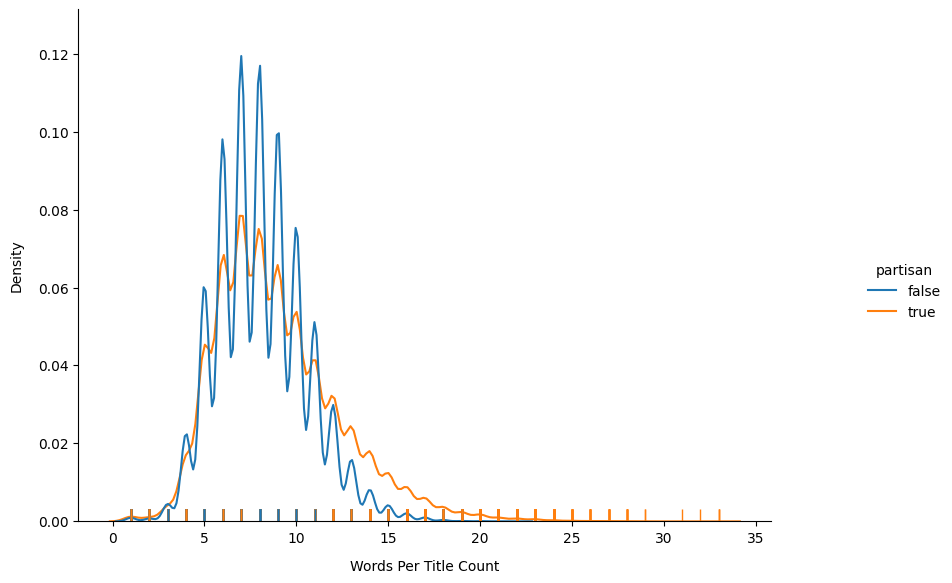

In [4]:
# Plot Title Word Count
dpgnews_df['title_wordcount'] = dpgnews_df.title.str.split(' ').str.len()
g = sns.displot(dpgnews_df, kind = 'kde', rug = True, x = 'title_wordcount', hue = 'partisan')
g.set_axis_labels('Words Per Title Count', 'Density', labelpad = 10)
g.fig.set_size_inches(10, 6)
plt.show()
plt.close()

The majority of titles are between 5 and 15 words long. No surprises there.
 
Next, the most interesting part...lets look at how much words there are for each article. Again we will look at the distribution of the article word count per label.

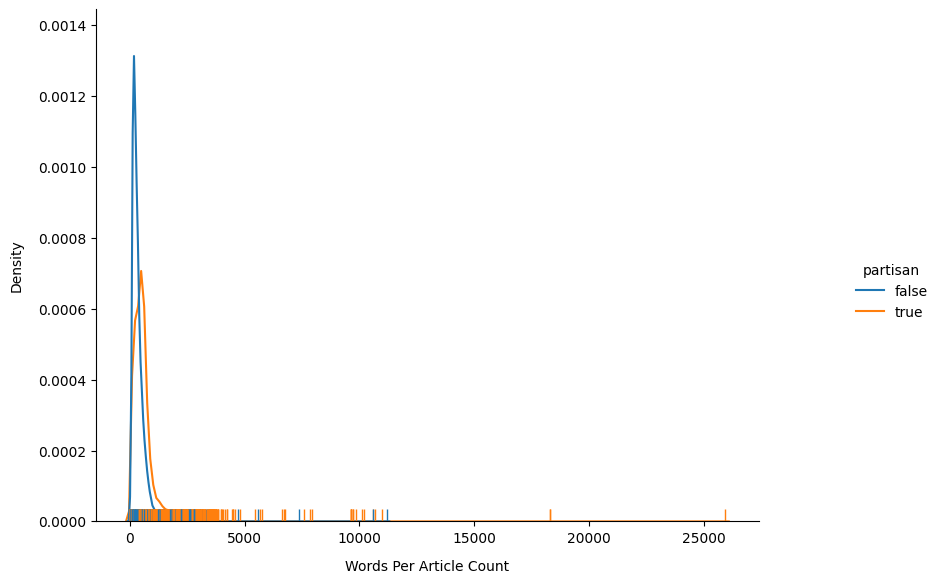

In [5]:
# Plot Text Word Count
dpgnews_df['text_wordcount'] = dpgnews_df.text.str.split(' ').str.len()
g = sns.displot(dpgnews_df, kind = 'kde', rug = True, x = 'text_wordcount', hue = 'partisan')
g.set_axis_labels('Words Per Article Count', 'Density', labelpad = 10)
g.fig.set_size_inches(10, 6)
plt.show()
plt.close()

We can see that the majority of articles has between 0 and roughly 2000 words. There are however a few spikes with articles containing over 25K+ words.

When training the models we will limit the maximum input length of words per article to use to 8192. As there are only a few articles with more words we won't loose much information while keeping the required training time for the models within limits.

It is also interesting to note that for articles with a partisan label of false there are more shorter articles (blue spike) compared to articles with a partisan label of true.

As a last plot we will look at the amount of sentences per article. This specific information we won't use when training the model. It does give additional information about the articles.

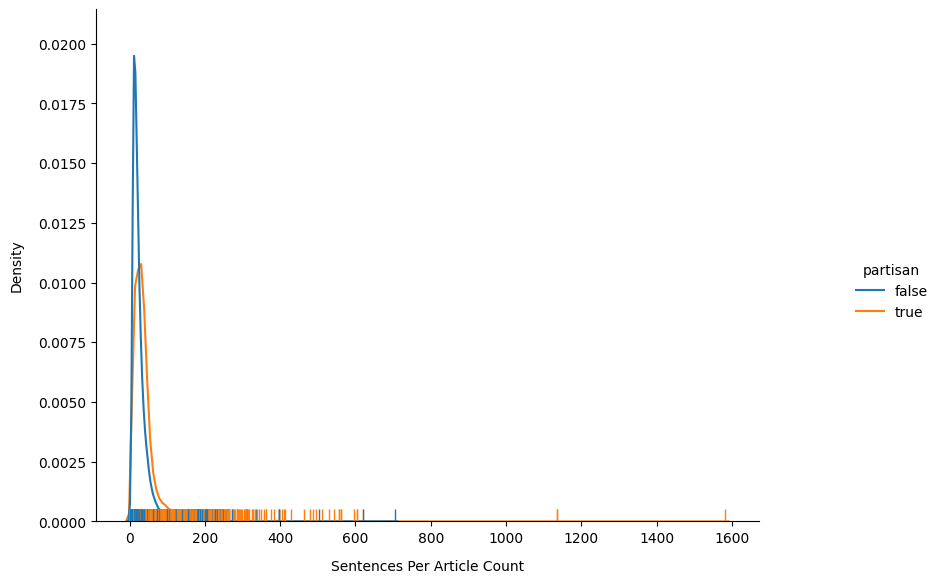

In [6]:
# Plot Sentence Count
dpgnews_df['text_sentence_count'] = dpgnews_df.text.str.split('.').str.len()
g = sns.displot(dpgnews_df, kind = 'kde', rug = True, x = 'text_sentence_count', hue = 'partisan')
g.set_axis_labels('Sentences Per Article Count', 'Density', labelpad = 10)
g.fig.set_size_inches(10, 6)
plt.show()
plt.close()

## The Experiment

To make the comparison we will perform 2 experiments. For each model we will build a custom grid search to determine the classification accuracy based on a 5 fold cross validation score.

Below is a high level description of what the code is doing.

We define 2 lists containing the parameters. With an outer for loop and an inner for loop we will loop over all values.

On each loop the Count Vectorizer will be configured with the value from the 'number_of_features' list. This value determines the amount of Top K words that the Count Vectorizer will look at when determining the feature vector. Notice that the only further processing done is lowercasing the input text and removing the stopwords.

Next the Count Vectorizer will be fit on all input text from the dataframe.

Next with a custom function we maximize the length of the input text. If the text of any article is longer than the value from 'text_lengths' than the article text will be limited to maximum that amount of words.

The (limited) article text will be transformed with the Count Vectorizer and assigned to variable X.

The partisan labels will be assigned to variable y.

The classifier model is specified. On all loops the parameters of the classifier remain the same to allow for an objective comparison. Note that tuning the model parameters could further improve the model performance.

Next the cross validation is performed based on a 5 fold cross validation.

The average accuracy score is calculated and assigned to a 2D Numpy array that will be used to contain the values for the heatmap plot.

In [7]:
# Function to maximize the text length for a given row
def maximize_text_length(text, max_length):
    text_list = text.split(' ')
    if len(text_list) > max_length:
        text_list = text_list[:max_length]
        text = ' '.join(text_list)
        return text
    else:
        return text

### Logistic Regression Model

In [8]:
# Value Lists to Perform Custom Grid Search
text_lengths = [128, 256, 512, 1024, 2048, 4096, 8192]
number_of_features = [128, 256, 512, 1024, 2048, 4096, 8192]

# Results Place Holder
heatmap_matrix = np.zeros((len(text_lengths), len(number_of_features)))

# Use Nested Loop
for i, text_length in enumerate(text_lengths):
    for j, number_features in enumerate(number_of_features):
        # Specify Count Vectorizer with specific number_of_features
        count_vectorizer = CountVectorizer(input = 'content', 
                                  encoding = 'utf-8', 
                                  lowercase = True, 
                                  stop_words = {'dutch'}, 
                                  analyzer = 'word', 
                                  max_features = number_features)

        # We fit the Count Vectorizer on all text in the original dataframe
        count_vectorizer.fit(dpgnews_df.text) 

        # Process the text in the dataframe to be of the required maximum length
        dpgnews_df['text_maxlength'] = dpgnews_df['text'].apply(maximize_text_length, max_length = text_length)

        # We transform however the text that is set to the maximum specified length
        X = count_vectorizer.transform(dpgnews_df.text_maxlength)
        y = dpgnews_df.partisan

        # Specify the Logistic Regression classifier. 
        # To make objective comparisons we keep the Logistic Regression parameters fixed.
        log_reg_clf = LogisticRegression(C = 1.0, 
                                         tol = 0.0001,
                                         solver = 'lbfgs', 
                                         max_iter = 100)

        # Perform Cross Validation Scoring. We use 5-fold Cross Validation                                
        cv_score = cross_val_score(log_reg_clf, 
                                   X, y, 
                                   cv = 5, 
                                   scoring = 'accuracy')

        # Plot Grid Parameters and Average Score for progress.
        score = np.mean(cv_score) * 100 # Take the average of all cross validation scores and multiply to get score in %      
        print(f'===== Text Length: {text_length} Number Of Features: {number_features} Accuracy: {score}') 

        # Add Result to matrix
        heatmap_matrix[i, j] = score                

===== Text Length: 128 Number Of Features: 128 Accuracy: 63.46105709059401
===== Text Length: 128 Number Of Features: 256 Accuracy: 66.36179840184846
===== Text Length: 128 Number Of Features: 512 Accuracy: 68.72340425531915
===== Text Length: 128 Number Of Features: 1024 Accuracy: 71.51535573312795
===== Text Length: 128 Number Of Features: 2048 Accuracy: 74.35063059593723
===== Text Length: 128 Number Of Features: 4096 Accuracy: 75.84384326562048
===== Text Length: 128 Number Of Features: 8192 Accuracy: 77.13199191296813
===== Text Length: 256 Number Of Features: 128 Accuracy: 66.7815538654087
===== Text Length: 256 Number Of Features: 256 Accuracy: 69.52151728121689
===== Text Length: 256 Number Of Features: 512 Accuracy: 72.07085780302302
===== Text Length: 256 Number Of Features: 1024 Accuracy: 74.44690478482718
===== Text Length: 256 Number Of Features: 2048 Accuracy: 76.92789063252143
===== Text Length: 256 Number Of Features: 4096 Accuracy: 78.17175315297969
===== Text Length: 

After running our custom Grid Search loops we have the heatmap_matrix filled with the validation accuracy results.

Lets plot a heatmap of those accuracy results.

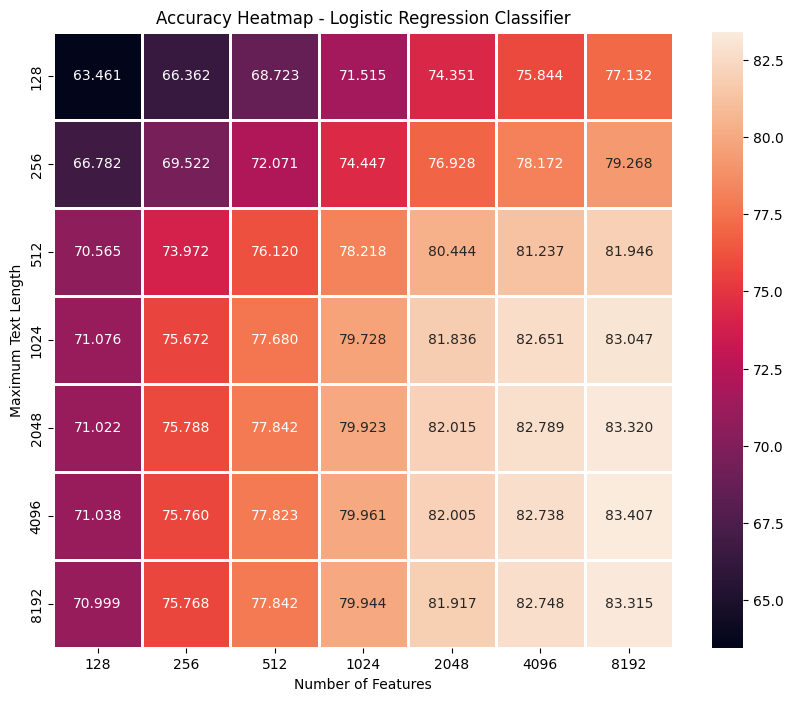

In [9]:
# Plot Accuracy Heatmap
plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(heatmap_matrix, 
                 annot = True,
                 xticklabels = number_of_features,
                 yticklabels = text_lengths,
                 fmt = '.3f',
                 linewidth = 1.0)
ax.set(xlabel = "Number of Features", ylabel = "Maximum Text Length")
ax.set(title = "Accuracy Heatmap - Logistic Regression Classifier")
plt.show()
plt.close()

### Random Forest Model

For the Random Forest model we perform the same custom grid search procedure as for the Logistic Regression model.

Do note that for the custom grid search parameters both values of 8192 have been removed. These values are to large for the Random Forest model to proces within an adequate timeframe.

In [10]:
# Value Lists to Perform Custom Grid Search
text_lengths = [128, 256, 512, 1024, 2048, 4096]
number_of_features = [128, 256, 512, 1024, 2048, 4096]

# Results Place Holder
heatmap_matrix = np.zeros((len(text_lengths), len(number_of_features)))

# Use Nested Loop
for i, text_length in enumerate(text_lengths):
    for j, number_features in enumerate(number_of_features):
        # Specify Count Vectorizer with specific number_of_features
        count_vectorizer = CountVectorizer(input = 'content', 
                                  encoding = 'utf-8', 
                                  lowercase = True, 
                                  stop_words = {'dutch'}, 
                                  analyzer = 'word', 
                                  max_features = number_features)

        # We fit the Count Vectorizer on all text in the original dataframe
        count_vectorizer.fit(dpgnews_df.text) 

        # Process the text in the dataframe to be of the required maximum length
        dpgnews_df['text_maxlength'] = dpgnews_df['text'].apply(maximize_text_length, max_length = text_length)

        # We transform however the text that is set to the maximum specified length
        X = count_vectorizer.transform(dpgnews_df.text_maxlength)
        y = dpgnews_df.partisan

        # Specify the Random Forest classifier. 
        # To make objective comparisons we keep the Random Forest Classifier parameters fixed.
        # Note: max_depth and max_leaf_nodes were chosen after some experimentation.
        # Setting those to the current numbers speeded up the training while not really effecting the achieved accuracy much.
        rfc_clf = RandomForestClassifier(n_estimators = 100, 
                                         max_depth = 8,
                                         max_leaf_nodes = 512)

        # Perform Cross Validation Scoring. We use 5-fold Cross Validation                                
        cv_score = cross_val_score(rfc_clf, 
                                   X, y, 
                                   cv = 5, 
                                   scoring = 'accuracy')

        # Plot Grid Parameters and Average Score for progress.
        score = np.mean(cv_score) * 100 # Take the average of all cross validation scores and multiply to get score in %      
        print(f'===== Text Length: {text_length} Number Of Features: {number_features} Accuracy: {score}') 

        # Add Result to matrix
        heatmap_matrix[i, j] = score                

===== Text Length: 128 Number Of Features: 128 Accuracy: 62.45499181669394
===== Text Length: 128 Number Of Features: 256 Accuracy: 65.04284201405603
===== Text Length: 128 Number Of Features: 512 Accuracy: 66.24241840762492
===== Text Length: 128 Number Of Features: 1024 Accuracy: 67.929142196977
===== Text Length: 128 Number Of Features: 2048 Accuracy: 69.5253682487725
===== Text Length: 128 Number Of Features: 4096 Accuracy: 69.73909694810821
===== Text Length: 256 Number Of Features: 128 Accuracy: 66.89130644074324
===== Text Length: 256 Number Of Features: 256 Accuracy: 69.16915374987965
===== Text Length: 256 Number Of Features: 512 Accuracy: 70.10590160777895
===== Text Length: 256 Number Of Features: 1024 Accuracy: 71.26696832579185
===== Text Length: 256 Number Of Features: 2048 Accuracy: 72.50986810436122
===== Text Length: 256 Number Of Features: 4096 Accuracy: 72.97198421103303
===== Text Length: 512 Number Of Features: 128 Accuracy: 70.40338885144892
===== Text Length: 512

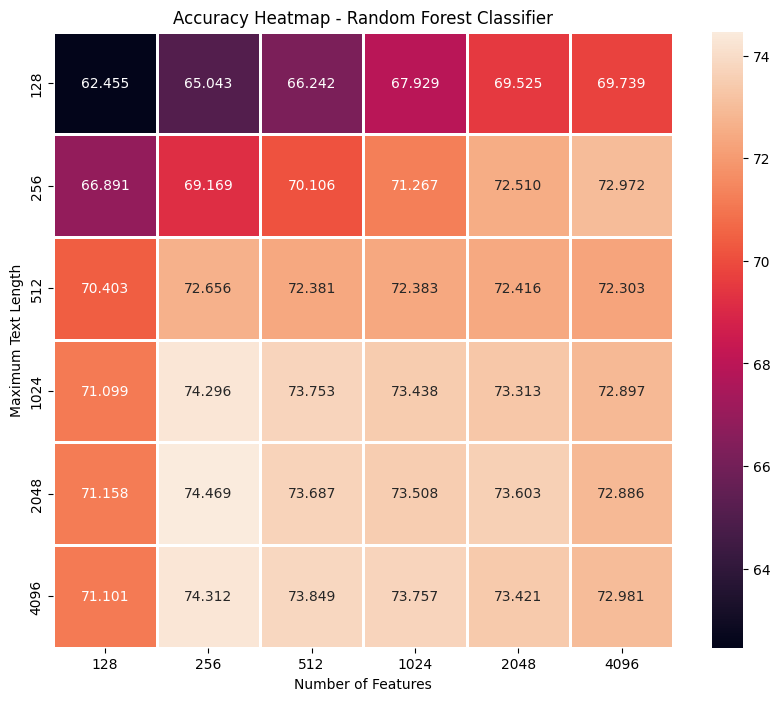

In [11]:
# Plot Accuracy Heatmap
plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(heatmap_matrix, 
                 annot = True,
                 xticklabels = number_of_features,
                 yticklabels = text_lengths,
                 fmt = '.3f',
                 linewidth = 1.0)
ax.set(xlabel = "Number of Features", ylabel = "Maximum Text Length")
ax.set(title = "Accuracy Heatmap - Random Forest Classifier")
plt.show()
plt.close()

## Results

First let's take a look at the overall results. The Logistic Regression model achieved a highest accuracy of 83.407% while the Random Forest Classifier achieved a highest score of only 74.469%. This is likely partially related to the fact that the parameters for the Random Forest Classifier have been modified to speed up the training proces.

It is likely that with the necessary model parameter tuning for both the models the gap in performance could be reduced.

One thing becomes very clear. The performance of the Logistic Regression model is a lot better than the Random Forest model. The Logistic Regression experiment trained a total of 49 models (7 * 7 grid parameters) in about 52 minutes. The Random Forest experiment trained a total of 36 models (6 * 6 grid parameters) in about 103 minutes. 

With a higher achieved accuracy and more than double the speed for training the models the Logistic Regression model is the preferred choice over the Random Forest classifier for the NLP classification task.

The heatmap of the Logistic Regression model shows that increasing the number of features or increasing the text_length leads to an increase in accuracy performance. 
An interesting point to notice is that for a fixed maximum text length there is more performance increase when increasing the maximum number of features than there is when keeping the maximum number of features fixed and increasing the maximum text length.
The likely explanation for this is that we need to increase the maximum number of features to be able to encode more usefull information. When increasing the maximum text length but not increasing the maximum number of features this severely limits the amount of usefull information for the model.
Overall it is still the best to increase both the maximum text length and the maximum number of features.
For the Random Forest model we can see that the best scores are just above the 74% accuracy. All these scores were however achieved with only 256 maximum number of features. This could be related to the modified parameters for the Random Forest model.

## Conclusions

In this notebook we experimented with solving a classification problem for NLP. We specifically looked at the effect of using different lengths of input text and using different values for the number of words that would be used as features by the Count Vectorizer.

By performing some basic Exploratory Data Analysis we were able to get a good impression of the dataset. With a size of 103K news articles it is large enough to allow for some interesting experiments. 

While most modern NLP problems can be solved with state of the art Transformer models we've shown that by using a 'classical' NLP approach - by using the Bag Of Words / Count Vectorizer to create the features and the Logistic Regression and Random Forest models to perform the classification - we were still able to get a very decent performance of 83+% accuracy with the Logistic Regression model.
The custom grid search could be expanded to also include the model parameters. This way it is likely that an even higher accuracy could be achieved.

An additional benefit of the 'classical' NLP approach is that this could all be achieved by running on regular CPU hardware without the use of any high-end GPU card. This makes it ideal to use for rapid prototyping before attempting to use the high-end models and hardware.